In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from seaborn import set_style
set_style("whitegrid")
import csv
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_poisson_deviance as mpd
import warnings
warnings.filterwarnings("ignore")

In [247]:
#Import the data
rec = pd.read_csv('NFLRecords.csv')
totalpicks = pd.read_csv('draftpicks.csv')
totalcombine_data = pd.read_csv('Data_Bowl_Combine.csv')
#Truncate data to the appropriate years
combine_data=totalcombine_data.loc[totalcombine_data['Year']%3!=0]
picks=totalpicks.loc[totalpicks['Year']%3!=0]
testcombine=totalcombine_data.loc[totalcombine_data['Year']%3==0]
testpicks=totalpicks.loc[totalpicks['Year']%3==0]
#Truncate data to the appropriate years
#combine_data=combine_data.loc[combine_data['Year']>2002]
#picks=picks.truncate(after=4079)

In [248]:
#Input 0 for anamolous DrAV values
picks['DrAV'].fillna(0)
for pick in picks.index:
    if picks.loc[pick,'DrAV']<0:
        picks.loc[pick,'DrAV']=0 

In [249]:
#Combine positions usually considered roughly equivalent
new = 'C', 'G', 'OG', 'OL', 'OT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'OL')
combine_data['Pos'].nunique()


new = 'FS', 'SS', 'S', 'DB', 'CB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DB')
combine_data['Pos'].nunique()


new = 'TE', 'FB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'TE')
combine_data['Pos'].nunique()

new = 'NT', 'DL', 'DT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DT')
combine_data['Pos'].nunique()


new = 'LB', 'OLB', 'ILB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'LB')
combine_data['Pos'].nunique()


new = 'EDGE'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DE')
combine_data['Pos'].nunique()


#Remove K, P, LS
new = 'K' , 'P' , 'LS'
combine_data = combine_data[~combine_data['Pos'].isin(new)]
combine_data['Pos'].nunique()


9

In [250]:
#Remove UDFAs and check how much data is missing.
no_UDFAs = combine_data[~combine_data['Pick'].isna()]
missing_no_UDFAs = no_UDFAs.isna().sum()
missing_no_UDFAs = missing_no_UDFAs/len(no_UDFAs) * 100
print(missing_no_UDFAs)

Player        0.000000
Pos           0.000000
Ht            0.000000
Wt            0.000000
Forty         4.471404
Vertical     19.722704
BenchReps    29.116118
BroadJump    20.970537
Cone         33.795494
Shuttle      33.136915
Team          0.000000
Round         0.000000
Pick          0.000000
Year          0.000000
Pfr_ID        1.663778
dtype: float64


In [251]:
#Add statistics to the data set.
no_UDFAs['DrAV']=[picks.loc[(picks['Tm']==no_UDFAs.loc[pick,'Team'])& (picks['Pick']==no_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in no_UDFAs.index]
#These statistics ended up not being predictable based on combine data.
#no_UDFAs['SRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['SRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'DSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'DSRS'].mean() for pick in no_UDFAs.index]

In [252]:
#We will estimate how much an individual draft pick is worth.
#I use a PoissonRegressor due to the right skew of the distribution.
dravreg=PoissonRegressor(alpha=0)
#The value of k and the exponent 0.5 were chosen via hyperparameter tuning 
k=180.01
draftpick=np.array([[(i+k)**(-0.5)] for i in range(1,257)])
picks['inv']=(picks['Pick']+k)**(-0.5)
dravreg.fit( picks[['inv']],picks['DrAV'])

PoissonRegressor(alpha=0)

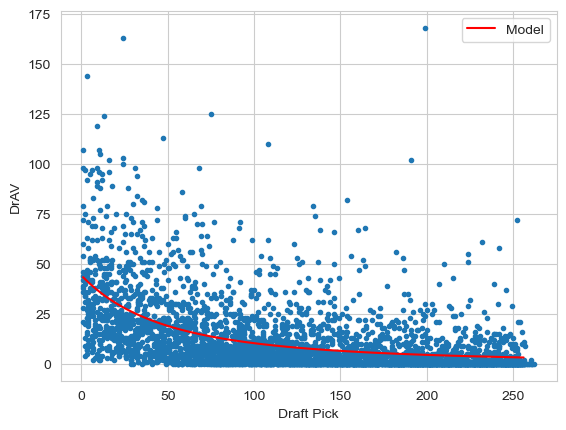

In [253]:
plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick),color='red', label='Model')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend();

In [254]:
# It was used to determine that combine data provided no further information than the draft slot about the teams future performance.

no_UDFAs['inv']=(no_UDFAs['Pick']+k)**(-0.5)

In [255]:
#A sanity check statistic; the average value of each position.
for Pos in ["QB", "RB", "WR","TE","OL","DE","DT","LB","DB"]:
    print("The average DrAV of a "+Pos+" is " + str(no_UDFAs.loc[no_UDFAs['Pos']==Pos, 'DrAV'].mean()))

The average DrAV of a QB is 19.049549549549546
The average DrAV of a RB is 13.71448087431694
The average DrAV of a WR is 11.680909863945576
The average DrAV of a TE is 7.133802816901408
The average DrAV of a OL is 16.136942675159236
The average DrAV of a DE is 16.047619047619047
The average DrAV of a DT is 12.955533596837945
The average DrAV of a LB is 14.706521739130435
The average DrAV of a DB is 11.252992220227409


We note that based on current NFL salaries this does not match teams valuation of the positions. This may cause error when comparing players from different positions using this metric.

In [256]:
#Filter the desired position
QB=no_UDFAs[no_UDFAs['Pos']=='QB']
#Interpolate blank values
QB=QB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#Model for the DrAV of a QB as a function of draft pick.
QBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
QBmodelAv.fit(QB[['inv']],QB['DrAV'])
#The main model predicting player performance based on combine data, the features were chosen by hyperparameter tuning.
#I used the full training set for the optimal model.
QBmodel=PoissonRegressor()
QBmodel.fit(QB[['Wt','Forty','BroadJump']],QB['DrAV'])
print(QBmodel.coef_)

[0.01200269 0.03063802 0.04091999]


In [257]:
RB=no_UDFAs[no_UDFAs['Pos']=='RB']
RB=RB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
RBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
RBmodelAv.fit(RB[['inv']],RB['DrAV'])
RBmodel=PoissonRegressor()
RBmodel.fit(RB[['Wt','Forty','Vertical','BroadJump','Cone','Shuttle']],RB['DrAV'])
print(RBmodel.coef_)

[ 0.00319581 -0.18677086 -0.02537735  0.04886766 -0.179269    0.15520935]


In [258]:
TE=no_UDFAs[no_UDFAs['Pos']=='TE']
TE=TE.fillna(value=TE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
TEmodelAv.fit(TE[['inv']],TE['DrAV'])
TEmodel=PoissonRegressor()
TEmodel.fit(TE[['Ht','Forty','BenchReps','BroadJump','Shuttle']],TE['DrAV'])
TEmodel.coef_

array([ 0.11459812, -0.10045472,  0.02127514,  0.05788356, -0.06214451])

In [259]:
OL=no_UDFAs[no_UDFAs['Pos']=='OL']
OL=OL.fillna(value=OL.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
OLmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
OLmodelAv.fit(OL[['inv']],OL['DrAV'])
OLmodel=PoissonRegressor()
OLmodel.fit(OL[['Vertical','BenchReps','Shuttle']],OL['DrAV'])
print(OLmodel.coef_)

[ 0.05258726  0.0027343  -0.28248438]


In [260]:
WR=no_UDFAs[no_UDFAs['Pos']=='WR']
WR=WR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
WRmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
WRmodelAv.fit(WR[['inv']],WR['DrAV'])
WRmodel=PoissonRegressor()
WRmodel.fit(WR[['Wt','Forty','Vertical']],WR['DrAV'])
print(WRmodel.coef_)


[ 0.00490808 -0.1499687   0.0385634 ]


In [261]:
DB=no_UDFAs[no_UDFAs['Pos']=='DB']
DB=DB[~no_UDFAs['DrAV'].isna()]
DB=DB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DBmodelAv.fit(DB[['inv']],DB['DrAV'])
DBmodel=PoissonRegressor()
DBmodel.fit(DB[['Ht','Wt','Forty','Cone','Shuttle']],DB['DrAV'])
print(DBmodel.coef_)

[-0.03117041  0.01611373 -0.14842942 -0.17570255 -0.13293686]


In [262]:
LB=no_UDFAs[no_UDFAs['Pos']=='LB']
LB=LB.fillna(value=LB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
LBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
LBmodelAv.fit(LB[['inv']],LB['DrAV'])
LBmodel=PoissonRegressor()
LBmodel.fit(LB[['Wt','Forty','Vertical','BenchReps','Cone','Shuttle']],LB['DrAV'])
print(LBmodel.coef_)

[ 0.01729254 -0.20833904  0.04499363 -0.00929322 -0.39697748 -0.31746745]


In [263]:
DT=no_UDFAs[no_UDFAs['Pos']=='DT']
DT=DT.fillna(value=DT.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DTmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DTmodelAv.fit(DT[['inv']],DT['DrAV'])
DTmodel=PoissonRegressor()
DTmodel.fit(DT[['Wt','Forty','BenchReps','Cone','Shuttle']],DT['DrAV'])
print(DTmodel.coef_)

[ 0.00829705 -0.29674176  0.02387659 -0.41126027 -0.01352204]


In [264]:
DE=no_UDFAs[no_UDFAs['Pos']=='DE']
DE=DE.fillna(value=DE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DEmodelAv.fit(DE[['inv']],DE['DrAV'])
DEmodel=PoissonRegressor()
DEmodel.fit(DE[['Wt','Forty','BenchReps','BroadJump','Cone','Shuttle']],DE['DrAV'])
print(DEmodel.coef_)

[ 0.0211488  -0.50406764  0.01900098  0.02776587 -0.07922732  0.08580122]


In [265]:
Models=[QBmodel,RBmodel,WRmodel,TEmodel,OLmodel,DEmodel,DTmodel,LBmodel,DBmodel]
ModelAv=[dravreg,QBmodelAv,RBmodelAv,WRmodelAv,TEmodelAv,OLmodelAv,DEmodelAv,DTmodelAv,LBmodelAv,DBmodelAv]

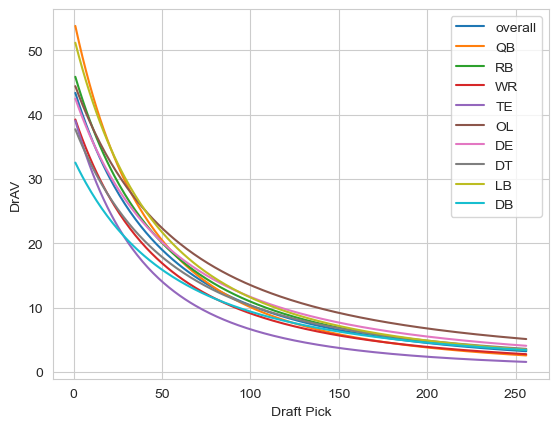

In [266]:
#plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick), label='overall')
plt.plot(range(1,257),QBmodelAv.predict(draftpick), label='QB')
plt.plot(range(1,257),RBmodelAv.predict(draftpick), label='RB')
plt.plot(range(1,257),WRmodelAv.predict(draftpick), label='WR')
plt.plot(range(1,257),TEmodelAv.predict(draftpick), label='TE')
plt.plot(range(1,257),OLmodelAv.predict(draftpick), label='OL')
plt.plot(range(1,257),DEmodelAv.predict(draftpick), label='DE')
plt.plot(range(1,257),DTmodelAv.predict(draftpick), label='DT')
plt.plot(range(1,257),LBmodelAv.predict(draftpick), label='LB')
plt.plot(range(1,257),DBmodelAv.predict(draftpick), label='DB')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend()

As a bonus result, we can give a table showing the value of a pick in the various rounds for each position. As expected first round quarterbacks are the most valuable.

In [267]:
table=np.array([model.predict([[(i+k)**-0.5 ] for i in [0,16,32,64,96,128,160,250]]) for model in ModelAv])

In [268]:
pd.DataFrame(table, index=["All","QB", "RB", "WR","TE","OL","DE","DT","LB","DB"], columns=[0,16,32,64,96,128,160,250])

,0,16,32,64,96,128,160,250
All,44.267656,32.619061,24.898169,15.746591,10.811881,7.884508,6.018575,3.334524
QB,55.079425,38.537328,28.098409,16.441896,10.591853,7.321285,5.338441,2.675819
RB,46.820970,34.487722,26.315899,16.633975,11.415968,8.321848,6.350334,3.515813
WR,40.067223,29.342687,22.275646,13.958439,9.511714,6.892342,5.232640,2.864767
TE,40.057876,27.447093,19.645428,11.140432,6.994191,4.731078,3.386521,1.630157
OL,45.181286,35.051046,28.000975,19.131028,13.995267,10.763973,8.599317,5.263087
DE,43.274833,32.851674,25.745243,17.026586,12.127506,9.120573,7.147966,4.195092
DT,38.423597,29.148747,22.829363,15.082520,10.733667,8.066559,6.318051,3.703066
LB,52.262481,38.069782,28.764607,17.880660,12.104549,8.722831,6.591124,3.571420
DB,33.120847,25.410062,20.100107,13.505300,9.745185,7.409328,5.861267,3.510846


In [269]:
#Import the testing data
testpicks = pd.read_csv('PicksTest.csv')
testcombine = pd.read_csv('TestCombineData.csv')


In [270]:
#Combine positions usually considered roughly equivalent
new = 'C', 'G', 'OG', 'OL', 'OT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'OL')
testcombine['Pos'].nunique()


new = 'FS', 'SS', 'S', 'DB', 'CB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DB')
testcombine['Pos'].nunique()


new = 'TE', 'FB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'TE')
testcombine['Pos'].nunique()

new = 'NT', 'DL', 'DT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DT')
testcombine['Pos'].nunique()


new = 'LB', 'OLB', 'ILB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'LB')
testcombine['Pos'].nunique()


new = 'EDGE'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DE')
testcombine['Pos'].nunique()


#Remove K, P, LS
new = 'K' , 'P' , 'LS'
testcombine = testcombine[~testcombine['Pos'].isin(new)]
testcombine['Pos'].nunique()

9

In [271]:
#Remove UDFAs
testno_UDFAs = testcombine[~testcombine['Pick'].isna()]
testno_UDFAs['DrAV']=[testpicks.loc[(testpicks['Tm']==testno_UDFAs.loc[pick,'Team'])& (testpicks['Pick']==testno_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in testno_UDFAs.index]

In [272]:
#A scaling statistic to account for the longer time older picks had to build up DrAV.
scale=no_UDFAs['DrAV'].mean()/testno_UDFAs['DrAV'].mean()
testno_UDFAs['adDrAV']=testno_UDFAs['DrAV']*scale

In [273]:
testno_UDFAs['inv']=(testno_UDFAs['Pick']+k)**(-0.5)

In [274]:
TestQB=testno_UDFAs[testno_UDFAs['Pos']=='QB']
TestQB=TestQB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestQB['DrAV'],QBmodel.predict(TestQB[['Wt','Forty','BroadJump']])))
TestQB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='QB', 'DrAV'].mean() for i in TestQB.index]
print(mpd(TestQB['DrAV'],TestQB['mean']))

25.493123571005352
26.268048186972393


In [275]:
TestRB=testno_UDFAs[testno_UDFAs['Pos']=='RB']
TestRB=TestRB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
print(mpd(TestRB['DrAV'],RBmodel.predict(TestRB[['Wt','Forty','Vertical','BroadJump','Cone','Shuttle']])))
TestRB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='RB', 'DrAV'].mean() for i in TestRB.index]
print(mpd(TestRB['DrAV'],TestRB['mean']))

12.936455649002822
13.192525920602533


In [276]:
TestWR=testno_UDFAs[testno_UDFAs['Pos']=='WR']
TestWR=TestWR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
print(mpd(TestWR['DrAV'],WRmodel.predict(TestWR[['Wt','Forty','Vertical']])))
TestWR['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='WR', 'DrAV'].mean() for i in TestWR.index]
print(mpd(TestWR['DrAV'],TestWR['mean']))

14.912879706193616
15.061400078545343


In [277]:
TestTE=testno_UDFAs[testno_UDFAs['Pos']=='TE']
TestTE=TestTE.fillna(value=TE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestTE['DrAV'],TEmodel.predict(TestTE[['Ht','Forty','BenchReps','BroadJump','Shuttle']])))
TestTE['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='TE', 'DrAV'].mean() for i in TestTE.index]
print(mpd(TestTE['DrAV'],TestTE['mean']))

7.965982267792201
8.141680338472106


In [278]:
TestOL=testno_UDFAs[testno_UDFAs['Pos']=='OL']
TestOL=TestOL.fillna(value=OL.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestOL['DrAV'],OLmodel.predict(TestOL[['Vertical','BenchReps','Shuttle']])))
TestOL['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='OL', 'DrAV'].mean() for i in TestOL.index]
print(mpd(TestOL['DrAV'],TestOL['mean']))

10.5634321100678
11.328830836155408


In [279]:
TestDT=testno_UDFAs[testno_UDFAs['Pos']=='DT']
TestDT=TestDT.fillna(value=DT.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestDT['DrAV'],DTmodel.predict(TestDT[['Wt','Forty','BenchReps','Cone','Shuttle']])))
TestDT['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='DT', 'DrAV'].mean() for i in TestDT.index]
print(mpd(TestDT['DrAV'],TestDT['mean']))

11.415032772491504
12.56572282393794


In [280]:
TestDE=testno_UDFAs[testno_UDFAs['Pos']=='DE']
TestDE=TestDE.fillna(value=DE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestDE['DrAV'],DEmodel.predict(TestDE[['Wt','Forty','BenchReps','BroadJump','Cone','Shuttle']])))
TestDE['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='DE', 'DrAV'].mean() for i in TestDE.index]
print(mpd(TestDE['DrAV'],TestDE['mean']))

13.118134243482611
18.912412904692662


In [281]:
TestLB=testno_UDFAs[testno_UDFAs['Pos']=='LB']
TestLB=TestLB.fillna(value=LB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestLB['DrAV'],LBmodel.predict(TestLB[['Wt','Forty','Vertical','BenchReps','Cone','Shuttle']])))
TestLB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='LB', 'DrAV'].mean() for i in TestLB.index]
print(mpd(TestLB['DrAV'],TestLB['mean']))

11.558778118615479
11.718998195895558


In [282]:
TestDB=testno_UDFAs[testno_UDFAs['Pos']=='DB']
TestDB=TestDB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#We compare the model to a dummy model that just looks at the mean.
print(mpd(TestDB['DrAV'],DBmodel.predict(TestDB[['Ht','Wt','Forty','Cone','Shuttle']])))
TestDB['mean']=[no_UDFAs.loc[no_UDFAs['Pos']=='DB', 'DrAV'].mean() for i in TestDB.index]
print(mpd(TestDB['DrAV'],TestDB['mean']))

7.366575103386911
7.364341372017634
